# 1. GTFS Data Preparation for Transit Optimization

This notebook shows functionality for preparing GTFS data for optimisation using the `transit_opt` package. It covers:

1.1 Setup and Data Loading
- Import libraries and configure paths
- Load GTFS data with GTFSDataPreparator
- Extract optimization data structure

1.2 Understanding the Data
- **Optimization data overview** (problem structure, decision matrix)
- **Route characteristics** (round-trip times, service patterns)
- **Time intervals and headway mapping**

1.3 Current Service Analysis  
- **Service coverage by time period**
- **Headway patterns** (simplified, focus on regular service)
- **Route activity visualization**

1.4 Fleet Requirements Analysis
- **Current fleet needs by interval**
- **Peak vs off-peak requirements**
- **Fleet efficiency opportunities**

In [1]:
import os
import sys

# Add the `src` directory to Python's module search path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Go up one level from `notebooks`
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

In [2]:
# Configure logging
import logging

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

from transit_opt.preprocessing.prepare_gtfs import GTFSDataPreparator

logging.basicConfig(level=logging.INFO)


## 1.1 Setup and Data Loading

This section loads a GTFS feed and creates the optimization data structure that will be used throughout the transit optimization workflow. The `GTFSDataPreparator` transforms raw GTFS files into a format suitable for mathematical optimization algorithms.

**Key outputs:**
- `opt_data`: Complete optimization data structure
- Route and interval definitions  
- Allowed headway choices (10, 15, 30, 60, 120 minutes + no service): existing headways are mapped to closest allowed value, and very long headways (>8 hours) are mapped to no service. In the downstream optimization, the model can choose any of these allowed headways for each route and time interval.

Read in the GTFS data using the `GTFSDataPreparator` class. The class is responsible for loading and preprocessing the GTFS data, making it suitable for optimization tasks.


In [3]:
preparator = GTFSDataPreparator(
    gtfs_path='../data/external/study_area_gtfs_bus.zip',
    interval_hours=3,  # 8 periods per day
    date=None,  # Use full GTFS feed (the gtfs feed should be for a single day, but mine is already filtered)
    turnaround_buffer=1.15,  # 15% buffer
    max_round_trip_minutes= 240.0,  # Maximum round-trip time in minutes
    no_service_threshold_minutes= 480.0,  # Threshold for no-service mapping
    log_level="DEBUG"  # Use "INFO" for production, "DEBUG" for development
)

# Define allowed headways
allowed_headways = [10, 15, 30, 60, 120]
# Extract all data from the GTFS feed needed for optimization
opt_data = preparator.extract_optimization_data(allowed_headways)


2025-09-25 15:43:07,797 - transit_opt.preprocessing.prepare_gtfs - INFO - Initializing GTFSDataPreparator with 3h intervals
INFO:transit_opt.preprocessing.prepare_gtfs:Initializing GTFSDataPreparator with 3h intervals
2025-09-25 15:43:07,798 - transit_opt.preprocessing.prepare_gtfs - DEBUG - Configuration: turnaround_buffer=1.15, max_round_trip=240.0min, no_service_threshold=480.0min
DEBUG:transit_opt.preprocessing.prepare_gtfs:Configuration: turnaround_buffer=1.15, max_round_trip=240.0min, no_service_threshold=480.0min
2025-09-25 15:43:07,799 - transit_opt.preprocessing.prepare_gtfs - INFO - Loading GTFS feed from ../data/external/study_area_gtfs_bus.zip
INFO:transit_opt.preprocessing.prepare_gtfs:Loading GTFS feed from ../data/external/study_area_gtfs_bus.zip
2025-09-25 15:43:11,255 - transit_opt.preprocessing.prepare_gtfs - DEBUG - GTFS feed loaded successfully: 187 routes, 13974 trips
DEBUG:transit_opt.preprocessing.prepare_gtfs:GTFS feed loaded successfully: 187 routes, 13974 trip

## 1.2 Understanding the Data
- **Optimization data overview** (problem structure, decision matrix)
- **Time intervals and headway mapping**


In [4]:
# =============================================================================
# UNDERSTANDING THE OPTIMIZATION PROBLEM STRUCTURE
# =============================================================================

print("=== MATHEMATICAL OPTIMIZATION STRUCTURE ===")
print("This section explains how real-world transit operations are converted into")
print("mathematical optimization variables that algorithms can work with.\n")

print("🔢 DECISION VARIABLES:")
print(f"   • Each route-interval combination = 1 optimization variable")
print(f"   • Matrix structure: {opt_data['decision_matrix_shape']} (routes × intervals)")
print(f"   • Total variables: {opt_data['decision_matrix_shape'][0] * opt_data['decision_matrix_shape'][1]}")
print(f"   • Each variable chooses from {opt_data['n_choices']} discrete headway options")

print(f"\n🎯 DISCRETE CHOICES:")
print(f"   • Continuous headways (e.g., 17.3 minutes) → Discrete choices (e.g., 15 minutes)")
print(f"   • Algorithms choose indices (0-{opt_data['n_choices']-1}) representing allowed headways")
print(f"   • Variable bounds: {opt_data['variable_bounds']} (choice indices)")

print(f"\n⏰ TIME STRUCTURE:")
print(f"   • Day divided into {opt_data['n_intervals']} intervals of {opt_data['intervals']['duration_minutes']//60} hours each")
print(f"   • Each route can have different headways in each time period")
print(f"   • Enables optimization of temporal service patterns")

print(f"\n🚌 ROUTE STRUCTURE:")
print(f"   • {opt_data['n_routes']} routes from GTFS feed")
print(f"   • Each route has {opt_data['n_intervals']} time-dependent variables")
print(f"   • Optimization can change service frequency by route and time")

print(f"\n📊 PROBLEM SCALE:")
print(f"   • Decision space: {opt_data['n_choices']}^{opt_data['decision_matrix_shape'][0] * opt_data['decision_matrix_shape'][1]} possible solutions")
print(f"   • Realistic for metaheuristic algorithms (PSO, genetic algorithms)")
print(f"   • Initial solution provides warm start from existing GTFS patterns")

=== MATHEMATICAL OPTIMIZATION STRUCTURE ===
This section explains how real-world transit operations are converted into
mathematical optimization variables that algorithms can work with.

🔢 DECISION VARIABLES:
   • Each route-interval combination = 1 optimization variable
   • Matrix structure: (147, 8) (routes × intervals)
   • Total variables: 1176
   • Each variable chooses from 6 discrete headway options

🎯 DISCRETE CHOICES:
   • Continuous headways (e.g., 17.3 minutes) → Discrete choices (e.g., 15 minutes)
   • Algorithms choose indices (0-5) representing allowed headways
   • Variable bounds: (0, 5) (choice indices)

⏰ TIME STRUCTURE:
   • Day divided into 8 intervals of 3 hours each
   • Each route can have different headways in each time period
   • Enables optimization of temporal service patterns

🚌 ROUTE STRUCTURE:
   • 147 routes from GTFS feed
   • Each route has 8 time-dependent variables
   • Optimization can change service frequency by route and time

📊 PROBLEM SCALE:
  

In [5]:
# =============================================================================
# DATA EXPLORATION: Understanding the Optimization Data Structure
# =============================================================================

print("=== OPTIMIZATION DATA OVERVIEW ===")
print(f"Problem Type: {opt_data['problem_type']}")
print(f"Decision Matrix Shape: {opt_data['decision_matrix_shape']}")
print(f"Variable Bounds: {opt_data['variable_bounds']}")
print(f"Number of Discrete Choices: {opt_data['n_choices']}")

print("\n=== ALLOWED HEADWAYS ===")
for i, headway in enumerate(opt_data['allowed_headways']):
    if headway >= 9000:
        print(f"  Index {i}: No Service ({headway})")
    else:
        print(f"  Index {i}: {headway:.0f} minutes")

print("\n=== TIME INTERVALS ===")
for i, (label, hours) in enumerate(zip(opt_data['intervals']['labels'], opt_data['intervals']['hours'], strict=False)):
    print(f"  Interval {i}: {label} ({hours[0]:02d}:00-{hours[1]:02d}:00)")

=== OPTIMIZATION DATA OVERVIEW ===
Problem Type: discrete_headway_optimization
Decision Matrix Shape: (147, 8)
Variable Bounds: (0, 5)
Number of Discrete Choices: 6

=== ALLOWED HEADWAYS ===
  Index 0: 10 minutes
  Index 1: 15 minutes
  Index 2: 30 minutes
  Index 3: 60 minutes
  Index 4: 120 minutes
  Index 5: No Service (9999.0)

=== TIME INTERVALS ===
  Interval 0: 00-03h (00:00-03:00)
  Interval 1: 03-06h (03:00-06:00)
  Interval 2: 06-09h (06:00-09:00)
  Interval 3: 09-12h (09:00-12:00)
  Interval 4: 12-15h (12:00-15:00)
  Interval 5: 15-18h (15:00-18:00)
  Interval 6: 18-21h (18:00-21:00)
  Interval 7: 21-24h (21:00-24:00)


## 1.3 Exploration of current service patterns

Understanding existing service patterns provides context before optimization. This analysis shows:

- **Service coverage by time period**
- **Headway patterns** (simplified, focus on regular service)
- **Route activity visualization**

In [6]:
# =============================================================================
# ROUTE CHARACTERISTICS ANALYSIS
# =============================================================================

route_ids = opt_data['routes']['ids']
round_trip_times = opt_data['routes']['round_trip_times']
current_headways = opt_data['routes']['current_headways']

print("=== ROUTE CHARACTERISTICS ===")
print(f"Total Routes: {len(route_ids)}")

print("\n🚌 ROUND-TRIP TIME DISTRIBUTION:")
print(f"  Min: {np.min(round_trip_times):.1f} minutes")
print(f"  Mean: {np.mean(round_trip_times):.1f} minutes")
print(f"  Median: {np.median(round_trip_times):.1f} minutes")
print(f"  Max: {np.max(round_trip_times):.1f} minutes")

# Categorize routes by round-trip time
short_routes = np.sum(round_trip_times <= 60)
medium_routes = np.sum((round_trip_times > 60) & (round_trip_times <= 120))
long_routes = np.sum(round_trip_times > 120)

print("\n🚌 ROUTE CATEGORIES BY DURATION:")
print(f"  Short Routes (≤60min): {short_routes} ({100*short_routes/len(route_ids):.1f}%)")
print(f"  Medium Routes (60-120min): {medium_routes} ({100*medium_routes/len(route_ids):.1f}%)")
print(f"  Long Routes (>120min): {long_routes} ({100*long_routes/len(route_ids):.1f}%)")

print("\n📊 SERVICE COVERAGE BY INTERVAL:")
for i, label in enumerate(opt_data['intervals']['labels']):
    active_routes = np.sum(~np.isnan(current_headways[:, i]))
    coverage_pct = 100 * active_routes / len(route_ids)
    print(f"  {label}: {active_routes}/{len(route_ids)} routes active ({coverage_pct:.1f}%)")

=== ROUTE CHARACTERISTICS ===
Total Routes: 147

🚌 ROUND-TRIP TIME DISTRIBUTION:
  Min: 23.0 minutes
  Mean: 117.1 minutes
  Median: 115.0 minutes
  Max: 232.3 minutes

🚌 ROUTE CATEGORIES BY DURATION:
  Short Routes (≤60min): 19 (12.9%)
  Medium Routes (60-120min): 63 (42.9%)
  Long Routes (>120min): 65 (44.2%)

📊 SERVICE COVERAGE BY INTERVAL:
  00-03h: 3/147 routes active (2.0%)
  03-06h: 60/147 routes active (40.8%)
  06-09h: 132/147 routes active (89.8%)
  09-12h: 113/147 routes active (76.9%)
  12-15h: 117/147 routes active (79.6%)
  15-18h: 134/147 routes active (91.2%)
  18-21h: 88/147 routes active (59.9%)
  21-24h: 65/147 routes active (44.2%)


In [7]:
# =============================================================================
# CURRENT HEADWAY PATTERNS ANALYSIS
# =============================================================================

print("=== CURRENT HEADWAY PATTERNS ===")

# Overall statistics - Filter out extreme values using threshold
valid_headways = current_headways[~np.isnan(current_headways)]
# Filter out values above the no-service threshold (typically 480 minutes = 8 hours)
regular_service_headways = valid_headways[valid_headways < preparator.no_service_threshold_minutes]

if len(regular_service_headways) > 0:
    print(f"\n📈 HEADWAY STATISTICS (regular service only, <{preparator.no_service_threshold_minutes:.0f}min):")
    print(f"  Min: {np.min(regular_service_headways):.1f} minutes")
    print(f"  Mean: {np.mean(regular_service_headways):.1f} minutes")
    print(f"  Median: {np.median(regular_service_headways):.1f} minutes")
    print(f"  Max: {np.max(regular_service_headways):.1f} minutes")
    print(f"  Count: {len(regular_service_headways):,} intervals (vs {len(valid_headways):,} total)")

    # Headway distribution (using regular service only)
    frequent = np.sum(regular_service_headways <= 15)
    moderate = np.sum((regular_service_headways > 15) & (regular_service_headways <= 60))
    infrequent = np.sum(regular_service_headways > 60)

    print("\n📊 SERVICE FREQUENCY DISTRIBUTION (regular service):")
    print(f"  Frequent Service (≤15min): {frequent} ({100*frequent/len(regular_service_headways):.1f}%)")
    print(f"  Moderate Service (15-60min): {moderate} ({100*moderate/len(regular_service_headways):.1f}%)")
    print(f"  Infrequent Service (>60min): {infrequent} ({100*infrequent/len(regular_service_headways):.1f}%)")

    # Show extreme values separately
    extreme_headways = valid_headways[valid_headways >= preparator.no_service_threshold_minutes]
    if len(extreme_headways) > 0:
        print(f"\n⚠️  IRREGULAR SERVICE (≥{preparator.no_service_threshold_minutes:.0f}min): {len(extreme_headways)} intervals")
        print("  These represent once-daily, once-weekly, or irregular services")
        print(f"  Values: {np.unique(extreme_headways)[:5]} {'...' if len(np.unique(extreme_headways)) > 5 else ''}")

else:
    print(f"\n⚠️  No regular service found (all headways ≥{preparator.no_service_threshold_minutes:.0f}min)")

# Service patterns by time of day (also filter extreme values)
print("\n🕐 AVERAGE HEADWAYS BY TIME OF DAY (regular service only):")
for i, label in enumerate(opt_data['intervals']['labels']):
    interval_headways = current_headways[:, i]
    valid_interval = interval_headways[~np.isnan(interval_headways)]
    regular_interval = valid_interval[valid_interval < preparator.no_service_threshold_minutes]

    if len(regular_interval) > 0:
        avg_headway = np.mean(regular_interval)
        print(f"  {label}: {avg_headway:.1f} min average ({len(regular_interval)} regular routes, {len(valid_interval)-len(regular_interval)} irregular)")
    elif len(valid_interval) > 0:
        irregular_count = len(valid_interval) - len(regular_interval)
        print(f"  {label}: No regular service ({irregular_count} irregular routes)")
    else:
        print(f"  {label}: No active routes")

=== CURRENT HEADWAY PATTERNS ===

📈 HEADWAY STATISTICS (regular service only, <480min):
  Min: 2.5 minutes
  Mean: 17.9 minutes
  Median: 12.7 minutes
  Max: 125.0 minutes
  Count: 626 intervals (vs 712 total)

📊 SERVICE FREQUENCY DISTRIBUTION (regular service):
  Frequent Service (≤15min): 363 (58.0%)
  Moderate Service (15-60min): 255 (40.7%)
  Infrequent Service (>60min): 8 (1.3%)

⚠️  IRREGULAR SERVICE (≥480min): 86 intervals
  These represent once-daily, once-weekly, or irregular services
  Values: [1440.] 

🕐 AVERAGE HEADWAYS BY TIME OF DAY (regular service only):
  00-03h: 33.3 min average (3 regular routes, 0 irregular)
  03-06h: 19.0 min average (51 regular routes, 9 irregular)
  06-09h: 16.2 min average (98 regular routes, 34 irregular)
  09-12h: 19.6 min average (111 regular routes, 2 irregular)
  12-15h: 20.2 min average (111 regular routes, 6 irregular)
  15-18h: 15.8 min average (107 regular routes, 27 irregular)
  18-21h: 15.1 min average (82 regular routes, 6 irregular)

In [8]:
# =============================================================================
# INITIAL SOLUTION ANALYSIS (EXISTING TRANSIT SERVICE)
# =============================================================================

initial_solution = opt_data['initial_solution']
allowed_headways = opt_data['allowed_headways']

print("=== INITIAL SOLUTION MAPPING ===")
print("How current GTFS headways map to discrete choices:\n")

# Count frequency of each choice in initial solution
choice_counts = {}
for choice_idx in range(opt_data['n_choices']):
    count = np.sum(initial_solution == choice_idx)
    choice_counts[choice_idx] = count

# Display mapping statistics
total_cells = initial_solution.size
for choice_idx in sorted(choice_counts.keys()):
    count = choice_counts[choice_idx]
    percentage = 100 * count / total_cells
    headway_val = allowed_headways[choice_idx]

    if headway_val >= 9000:
        print(f"  Choice {choice_idx} (No Service): {count:,} cells ({percentage:.1f}%)")
    else:
        print(f"  Choice {choice_idx} ({headway_val:.0f}min): {count:,} cells ({percentage:.1f}%)")

service_cells = total_cells - choice_counts.get(opt_data['no_service_index'], 0)
print(f"\nOverall: {service_cells:,}/{total_cells:,} cells with active service ({100*service_cells/total_cells:.1f}%)")

=== INITIAL SOLUTION MAPPING ===
How current GTFS headways map to discrete choices:

  Choice 0 (10min): 312 cells (26.5%)
  Choice 1 (15min): 156 cells (13.3%)
  Choice 2 (30min): 121 cells (10.3%)
  Choice 3 (60min): 34 cells (2.9%)
  Choice 4 (120min): 3 cells (0.3%)
  Choice 5 (No Service): 550 cells (46.8%)

Overall: 626/1,176 cells with active service (53.2%)


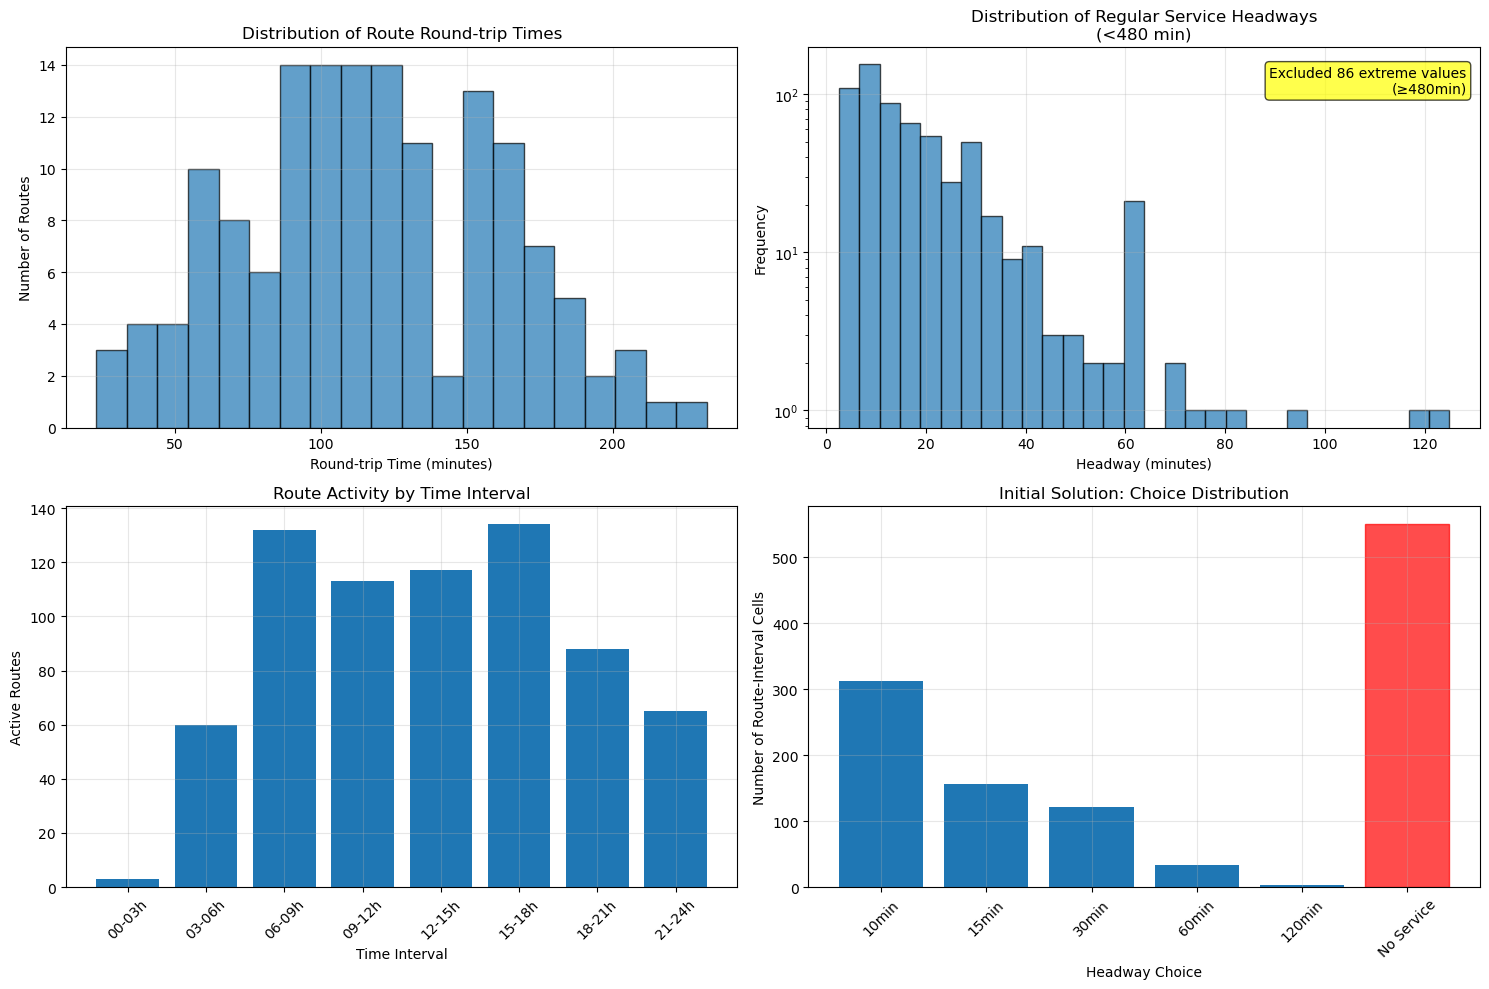


Visualization shows:
  • Route complexity (round-trip times)
  • Regular service frequency patterns (extreme values filtered)
  • When routes are most/least active
  • How existing service maps to optimization choices


In [9]:
# =============================================================================
# VISUALIZE CURRENT SERVICE PATTERNS
# =============================================================================

# Create a comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Round-trip time distribution (unchanged)
axes[0,0].hist(round_trip_times, bins=20, alpha=0.7, edgecolor='black')
axes[0,0].set_xlabel('Round-trip Time (minutes)')
axes[0,0].set_ylabel('Number of Routes')
axes[0,0].set_title('Distribution of Route Round-trip Times')
axes[0,0].grid(True, alpha=0.3)

# 2. Valid headways distribution - filter extreme values
valid_headways = current_headways[~np.isnan(current_headways)]
regular_service_headways = valid_headways[valid_headways < preparator.no_service_threshold_minutes]

if len(regular_service_headways) > 0:
    axes[0,1].hist(regular_service_headways, bins=30, alpha=0.7, edgecolor='black')
    axes[0,1].set_xlabel('Headway (minutes)')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title(f'Distribution of Regular Service Headways\n(<{preparator.no_service_threshold_minutes:.0f} min)')
    axes[0,1].set_yscale('log')
    axes[0,1].grid(True, alpha=0.3)

    # Add text showing filtered count
    extreme_count = len(valid_headways) - len(regular_service_headways)
    axes[0,1].text(0.98, 0.95, f'Excluded {extreme_count} extreme values\n(≥{preparator.no_service_threshold_minutes:.0f}min)',
                   transform=axes[0,1].transAxes, ha='right', va='top',
                   bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
else:
    axes[0,1].text(0.5, 0.5, 'No Regular Service\nFound',
                   ha='center', va='center', transform=axes[0,1].transAxes)
    axes[0,1].set_title('Distribution of Regular Service Headways')

# 3. Service coverage by interval (unchanged)
interval_labels = opt_data['intervals']['labels']
active_counts = [np.sum(~np.isnan(current_headways[:, i])) for i in range(opt_data['n_intervals'])]

axes[1,0].bar(range(len(active_counts)), active_counts)
axes[1,0].set_xlabel('Time Interval')
axes[1,0].set_ylabel('Active Routes')
axes[1,0].set_title('Route Activity by Time Interval')
axes[1,0].set_xticks(range(len(interval_labels)))
axes[1,0].set_xticklabels(interval_labels, rotation=45)
axes[1,0].grid(True, alpha=0.3)

# 4. Initial solution choice distribution (unchanged)
choice_labels = [f"{h:.0f}min" if h < 9000 else "No Service" for h in allowed_headways]
choice_counts_list = [choice_counts.get(i, 0) for i in range(opt_data['n_choices'])]

bars = axes[1,1].bar(range(len(choice_counts_list)), choice_counts_list)
axes[1,1].set_xlabel('Headway Choice')
axes[1,1].set_ylabel('Number of Route-Interval Cells')
axes[1,1].set_title('Initial Solution: Choice Distribution')
axes[1,1].set_xticks(range(len(choice_labels)))
axes[1,1].set_xticklabels(choice_labels, rotation=45)

# Highlight no-service bar
bars[opt_data['no_service_index']].set_color('red')
bars[opt_data['no_service_index']].set_alpha(0.7)

axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nVisualization shows:")
print("  • Route complexity (round-trip times)")
print("  • Regular service frequency patterns (extreme values filtered)")
print("  • When routes are most/least active")
print("  • How existing service maps to optimization choices")

## 1.4 Fleet requirement analysis

Our optimisation problem will have constraints on the number of vehicles available. Fleet size is a proxy for operational cost, so our optimisation problem will be constrained to the current fleet size, or an increase of x%. 

Our optimisation problem will work by assigning headways, not vehicles. We need to calculate how many vehicles are needed to operate the current service (based on headways and round-trip times), to set a baseline for the optimisation problem. We will also be caulating the required fleet size for each optimisation solution to check if it exceeds our fleet limit constraint (more on that later)

Here weheck the `fleet_analysis` output to see the fleet requirements of the existing service


In [10]:
# Comprehensive fleet analysis display
fleet_analysis = opt_data['constraints']['fleet_analysis']

print("=== FLEET ANALYSIS SUMMARY ===")
print(f"📊 Total Routes: {opt_data['n_routes']}")
print(f"📊 Active Routes: {fleet_analysis['fleet_stats']['routes_with_service']}")
print(f"📊 Time Intervals: {opt_data['n_intervals']} ({opt_data['intervals']['duration_minutes']//60}h each)")

print("\n🚗 FLEET REQUIREMENTS:")
print(f"Peak Fleet Needed: {fleet_analysis['total_current_fleet_peak']} vehicles")
print(f"Fleet by Interval: {fleet_analysis['current_fleet_by_interval'].tolist()}")
print(f"Peak Interval: {fleet_analysis['fleet_stats']['peak_interval']} ({opt_data['intervals']['labels'][fleet_analysis['fleet_stats']['peak_interval']]})")
print(f"Off-Peak Minimum: {fleet_analysis['fleet_stats']['off_peak_fleet']} vehicles")

print("\n📈 EFFICIENCY:")
efficiency_gain = fleet_analysis['fleet_stats']['fleet_efficiency_gain']
if efficiency_gain > 0:
    print(f"Efficiency Gain: {efficiency_gain} vehicles saved ({efficiency_gain/(fleet_analysis['total_current_fleet_peak']+efficiency_gain)*100:.1f}% reduction)")
else:
    print("No efficiency gain (all routes peak simultaneously)")

print("\n🔧 ROUTE DISTRIBUTION:")
dist = fleet_analysis['fleet_stats']['fleet_distribution']
print(f"Small Routes (1-5 vehicles): {dist['small_routes']}")
print(f"Medium Routes (6-15 vehicles): {dist['medium_routes']}")
print(f"Large Routes (>15 vehicles): {dist['large_routes']}")

print("\n⚙️ CONFIGURATION:")
print(f"Operational Buffer: {fleet_analysis['operational_buffer']} ({(fleet_analysis['operational_buffer']-1)*100:.0f}% extra time)")

=== FLEET ANALYSIS SUMMARY ===
📊 Total Routes: 147
📊 Active Routes: 115
📊 Time Intervals: 8 (3h each)

🚗 FLEET REQUIREMENTS:
Peak Fleet Needed: 1263 vehicles
Fleet by Interval: [11, 585, 1181, 1217, 1202, 1263, 1012, 690]
Peak Interval: 5 (15-18h)
Off-Peak Minimum: 11 vehicles

📈 EFFICIENCY:
Efficiency Gain: 98 vehicles saved (7.2% reduction)

🔧 ROUTE DISTRIBUTION:
Small Routes (1-5 vehicles): 28
Medium Routes (6-15 vehicles): 53
Large Routes (>15 vehicles): 34

⚙️ CONFIGURATION:
Operational Buffer: 1.15 (15% extra time)


One of the possible constraints in our optimisation problem is the number of vehicles per time interval. Below we show this breakdown for the existing service

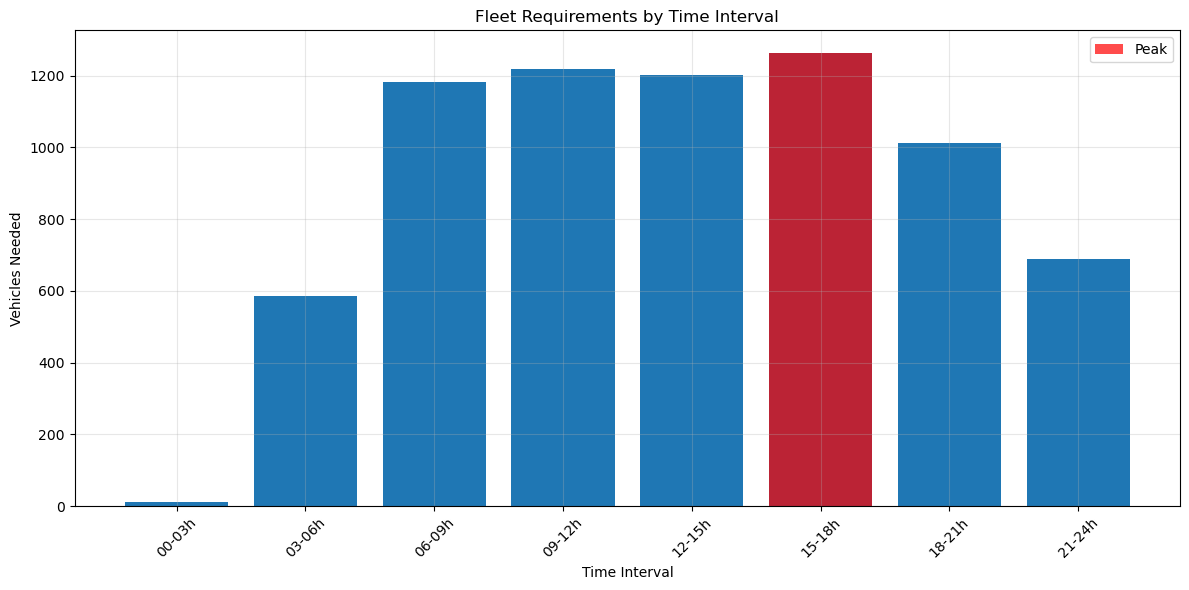

Peak occurs during 15-18h with 1263 vehicles needed


In [11]:
# Plot fleet requirements by interval
import matplotlib.pyplot as plt

fleet_by_interval = fleet_analysis['current_fleet_by_interval']
interval_labels = opt_data['intervals']['labels']

plt.figure(figsize=(12, 6))
plt.bar(range(len(fleet_by_interval)), fleet_by_interval)
plt.xlabel('Time Interval')
plt.ylabel('Vehicles Needed')
plt.title('Fleet Requirements by Time Interval')
plt.xticks(range(len(interval_labels)), interval_labels, rotation=45)
plt.grid(True, alpha=0.3)

# Highlight peak interval
peak_idx = fleet_analysis['fleet_stats']['peak_interval']
plt.bar(peak_idx, fleet_by_interval[peak_idx], color='red', alpha=0.7, label='Peak')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Peak occurs during {interval_labels[peak_idx]} with {fleet_by_interval[peak_idx]} vehicles needed")

Spatial analysis enables coverage-based optimization objectives. This section demonstrates:

- **Study Area Definition**: Geographic boundary for optimization focus
- **Hexagonal Grid**: Spatial zones for measuring service coverage
- **Objective Function Setup**: How spatial coverage will be measured in optimization

This creates the foundation for optimizing service equity and accessibility across the study area.

## Objective functions

### Spatial coverage

In [12]:
from transit_opt.optimisation.objectives import HexagonalCoverageObjective
from transit_opt.optimisation.spatial.boundaries import StudyAreaBoundary

In [13]:
# Add this as a new cell to test boundary functionality
print("=== DEMONSTRATING BOUNDARY FUNCTIONALITY ===")

# Read in the boundary layer

boundary_gdf = gpd.read_file("../data/external/boundaries/study_area_boundary.geojson")

# Create StudyAreaBoundary
study_boundary = StudyAreaBoundary(
    boundary_gdf=boundary_gdf,
    crs="EPSG:3857",  # Convert to metric
    buffer_km=2.0     # Add 2km buffer
)

print(f"✅ Created study area boundary in {study_boundary.target_crs}")


=== DEMONSTRATING BOUNDARY FUNCTIONALITY ===
✅ Validated metric CRS: EPSG:3857
🔄 Converting boundary CRS: EPSG:4326 → EPSG:3857
📏 Applied 2.0km buffer
✅ Study area set: 1 polygon(s) in EPSG:3857
✅ Created study area boundary in EPSG:3857



=== TESTING BOUNDARY FILTERING ===
📊 Original data:
   Total stops in GTFS: 6897
🔍 Filtered 6897 → 4405 points

📊 After boundary filtering:
   Stops within study area: 4405
   Reduction: 2492 stops (36.1%)


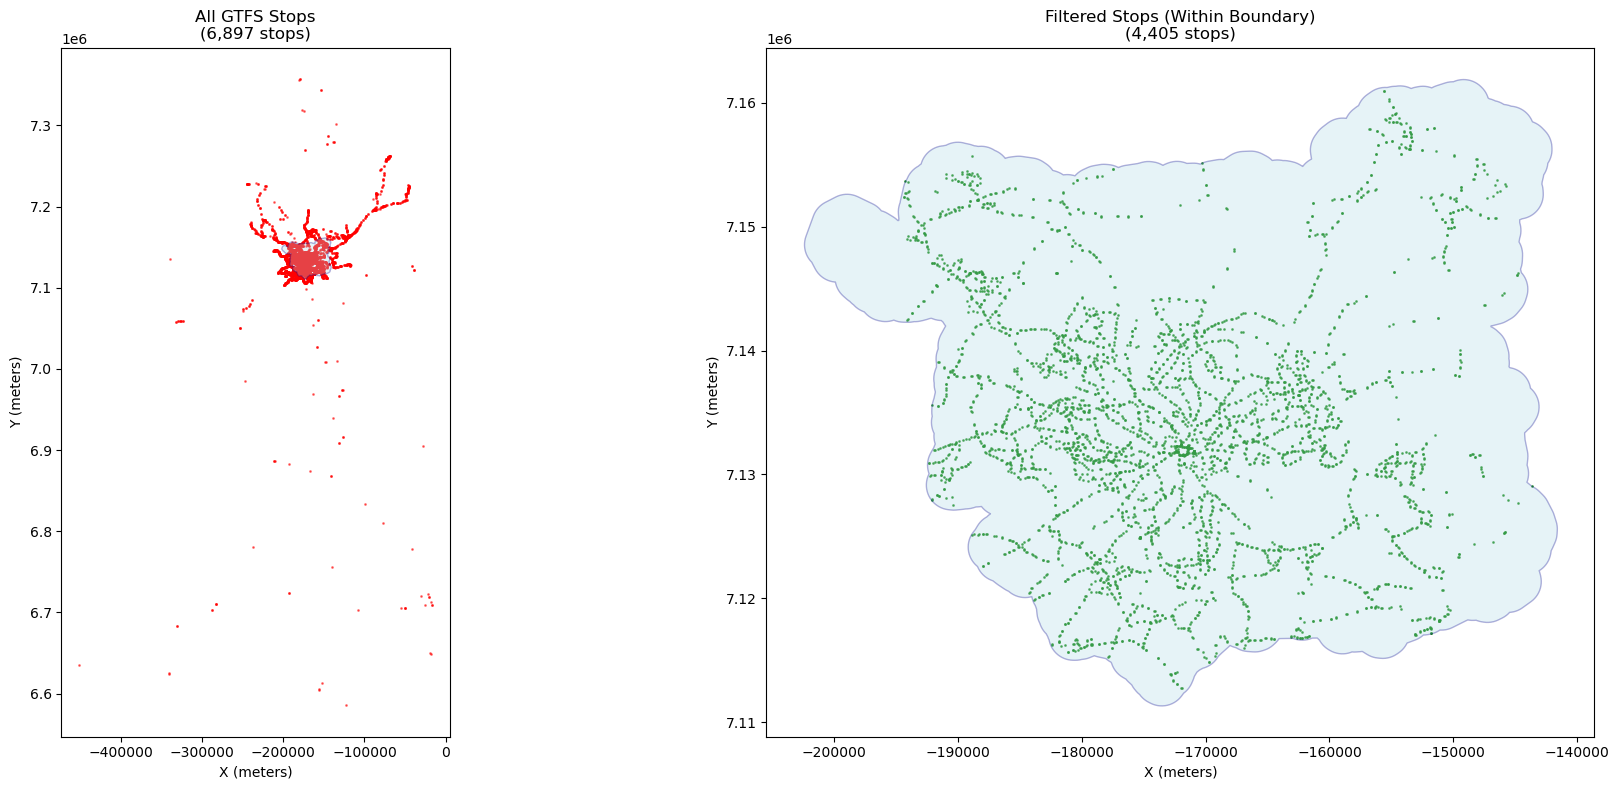

✅ Boundary filtering visualization created in EPSG:3857!
🗺️  All coordinates shown in meters (Web Mercator projection)


In [14]:
if study_boundary is not None:
    print("\n=== TESTING BOUNDARY FILTERING ===")

    gtfs_feed = opt_data['reconstruction']['gtfs_feed']

    # Create stops GeoDataFrame for filtering
    stops_gdf = gpd.GeoDataFrame(
        gtfs_feed.stops,
        geometry=gpd.points_from_xy(gtfs_feed.stops.stop_lon, gtfs_feed.stops.stop_lat),
        crs="EPSG:4326"
    )

    print("📊 Original data:")
    print(f"   Total stops in GTFS: {len(stops_gdf)}")

    # Filter stops using boundary
    filtered_stops = study_boundary.filter_points(stops_gdf, output_crs="EPSG:3857")

    print("\n📊 After boundary filtering:")
    print(f"   Stops within study area: {len(filtered_stops)}")
    print(f"   Reduction: {len(stops_gdf) - len(filtered_stops)} stops ({100*(len(stops_gdf) - len(filtered_stops))/len(stops_gdf):.1f}%)")

    # Create a comparison visualization - ALL IN EPSG:3857
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Convert original stops to EPSG:3857 for consistent plotting
    stops_gdf_metric = stops_gdf.to_crs("EPSG:3857")

    # Plot 1: Original stops (converted to EPSG:3857)
    axes[0].scatter(stops_gdf_metric.geometry.x, stops_gdf_metric.geometry.y,
                   c='red', alpha=0.5, s=1)
    study_boundary.visualize(ax=axes[0], viz_crs="EPSG:3857",
                           facecolor='lightblue', alpha=0.3)
    axes[0].set_title(f'All GTFS Stops\n({len(stops_gdf):,} stops)')
    axes[0].set_xlabel('X (meters)')
    axes[0].set_ylabel('Y (meters)')

    # Plot 2: Filtered stops (already in EPSG:3857)
    axes[1].scatter(filtered_stops.geometry.x, filtered_stops.geometry.y,
                   c='green', alpha=0.7, s=1)
    study_boundary.visualize(ax=axes[1], viz_crs="EPSG:3857",
                           facecolor='lightblue', alpha=0.3)
    axes[1].set_title(f'Filtered Stops (Within Boundary)\n({len(filtered_stops):,} stops)')
    axes[1].set_xlabel('X (meters)')
    axes[1].set_ylabel('Y (meters)')

    # Set equal aspect ratio for both plots
    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')

    plt.tight_layout()
    plt.show()

    print("✅ Boundary filtering visualization created in EPSG:3857!")
    print("🗺️  All coordinates shown in meters (Web Mercator projection)")

In [15]:
# Add this as a new cell to test the integrated system with spatial lag
if study_boundary is not None:
    print("\n=== TESTING BOUNDARY-AWARE HEXAGONAL COVERAGE OBJECTIVE WITH SPATIAL LAG ===")

    # Create objective WITHOUT boundary (for comparison)
    spatial_objective_full = HexagonalCoverageObjective(
        optimization_data=opt_data,
        spatial_resolution_km=3.0,
        crs="EPSG:3857"
    )

    # Create objective WITH boundary - STANDARD VERSION
    spatial_objective_bounded = HexagonalCoverageObjective(
        optimization_data=opt_data,
        spatial_resolution_km=3.0,
        crs="EPSG:3857",
        boundary=study_boundary,
        spatial_lag=False  # Standard variance
    )

    # Create objective WITH boundary - SPATIAL LAG VERSION
    spatial_objective_spatial = HexagonalCoverageObjective(
        optimization_data=opt_data,
        spatial_resolution_km=3.0,
        crs="EPSG:3857",
        boundary=study_boundary,
        spatial_lag=True,   # Enable spatial lag
        alpha=0.15          # 15% neighbor influence
    )

    print("\n📊 COMPARISON:")
    print("Full system:")
    print(f"   Zones: {len(spatial_objective_full.spatial_system.hex_grid)}")
    print(f"   Stops: {len(spatial_objective_full.spatial_system.stops_gdf)}")

    print("Bounded system (standard):")
    print(f"   Zones: {len(spatial_objective_bounded.spatial_system.hex_grid)}")
    print(f"   Stops: {len(spatial_objective_bounded.spatial_system.stops_gdf)}")

    print("Bounded system (spatial lag α=0.15):")
    print(f"   Zones: {len(spatial_objective_spatial.spatial_system.hex_grid)}")
    print(f"   Stops: {len(spatial_objective_spatial.spatial_system.stops_gdf)}")

    zone_reduction = len(spatial_objective_full.spatial_system.hex_grid) - len(spatial_objective_bounded.spatial_system.hex_grid)
    stop_reduction = len(spatial_objective_full.spatial_system.stops_gdf) - len(spatial_objective_bounded.spatial_system.stops_gdf)

    print("\nReduction from boundary:")
    print(f"   Zones: -{zone_reduction} ({100*zone_reduction/len(spatial_objective_full.spatial_system.hex_grid):.1f}%)")
    print(f"   Stops: -{stop_reduction} ({100*stop_reduction/len(spatial_objective_full.spatial_system.stops_gdf):.1f}%)")

    # Test evaluations - comparing standard vs spatial lag
    print("\n🎯 OBJECTIVE FUNCTION COMPARISON:")

    # Standard variance evaluation
    standard_objective = spatial_objective_bounded.evaluate(opt_data['initial_solution'])
    print(f"Standard variance objective: {standard_objective:.4f}")

    # Spatial lag variance evaluation
    spatial_objective_val = spatial_objective_spatial.evaluate(opt_data['initial_solution'])
    print(f"Spatial lag variance objective (α=0.15): {spatial_objective_val:.4f}")

    # Get detailed analyses
    standard_analysis = spatial_objective_bounded.get_detailed_analysis(opt_data['initial_solution'])
    spatial_analysis = spatial_objective_spatial.get_detailed_analysis(opt_data['initial_solution'])

    print("\n📈 DETAILED ANALYSIS COMPARISON:")
    print("Standard approach:")
    print(f"   Total vehicles (average): {standard_analysis['total_vehicles_average']}")
    print(f"   Zones with service: {standard_analysis['zones_with_service_average']}")
    print(f"   Variance: {standard_analysis['variance_average']:.4f}")
    print(f"   Coefficient of variation: {standard_analysis['coefficient_of_variation_average']:.4f}")

    print("\nSpatial lag approach (α=0.15):")
    print(f"   Total vehicles (average): {spatial_analysis['total_vehicles_average']}")
    print(f"   Zones with service: {spatial_analysis['zones_with_service_average']}")
    print(f"   Standard variance: {spatial_analysis['variance_average']:.4f}")
    print(f"   Accessibility variance: {spatial_analysis['variance_accessibility_average']:.4f}")
    print(f"   Mean accessibility: {spatial_analysis['mean_accessibility_average']:.2f}")
    print(f"   Coefficient of variation: {spatial_analysis['coefficient_of_variation_average']:.4f}")

    # Compare the effect of spatial lag
    improvement_zones = np.sum(spatial_analysis['accessibility_scores_average'] > spatial_analysis['vehicles_per_zone_average'])
    print("\n🌟 SPATIAL LAG EFFECTS:")
    print(f"   Zones with improved accessibility: {improvement_zones} out of {len(spatial_analysis['vehicles_per_zone_average'])}")
    print(f"   Accessibility boost: {spatial_analysis['mean_accessibility_average'] - spatial_analysis['mean_vehicles_average']:.2f} vehicles per zone on average")

    # Test different alpha values
    print("\n🔬 TESTING DIFFERENT ALPHA VALUES:")
    alpha_values = [0.0, 0.05, 0.1, 0.2, 0.3]

    for alpha in alpha_values:
        test_objective = HexagonalCoverageObjective(
            optimization_data=opt_data,
            spatial_resolution_km=3.0,
            crs="EPSG:3857",
            boundary=study_boundary,
            spatial_lag=(alpha > 0),
            alpha=alpha
        )

        test_value = test_objective.evaluate(opt_data['initial_solution'])
        print(f"   α = {alpha:.2f}: variance = {test_value:.4f}")


=== TESTING BOUNDARY-AWARE HEXAGONAL COVERAGE OBJECTIVE WITH SPATIAL LAG ===
🗺️ Setting up spatial analysis with 3.0km resolution
🗺️  Reprojected 6897 stops to EPSG:3857
🔧 Creating 146 × 259 = 37814 grid cells
   Grid bounds: (-453051, 6584019) to (-15085, 7358492) meters
   Cell size: 3000.0m × 3000.0m
✅ Created 37814 hexagonal zones in EPSG:3857
🚀 Using spatial join for zone mapping...
✅ Mapped 6897 stops to zones
🚀 Pre-computing route-stop mappings...
✅ Cached stops for 187 routes
✅ Spatial system ready: 37814 hexagonal zones
🗺️ Setting up spatial analysis with 3.0km resolution
🗺️  Reprojected 6897 stops to EPSG:3857
🎯 Applying boundary filter to 6897 stops...
🔍 Filtered 6897 → 4405 points
✅ Filtered to 4405 stops within boundary
🔧 Creating 18 × 18 = 324 grid cells
   Grid bounds: (-195846, 7111259) to (-142157, 7162476) meters
   Cell size: 3000.0m × 3000.0m
✅ Created 324 hexagonal zones in EPSG:3857
🎯 Applying boundary filter to 324 grid cells...
🔍 Filtered 324 → 251 grid cells
✅


=== VISUALIZING BOUNDARY-FILTERED SYSTEM WITH SPATIAL LAG COMPARISON ===
📊 Full System (No Boundary):


/home/hussein/Documents/GitHub/transit_opt/src/transit_opt/optimisation/spatial/zoning.py:729: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/hussein/Documents/GitHub/transit_opt/src/transit_opt/optimisation/spatial/zoning.py:729: UserWarning: Glyph 128652 (\N{BUS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128652 (\N{BUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


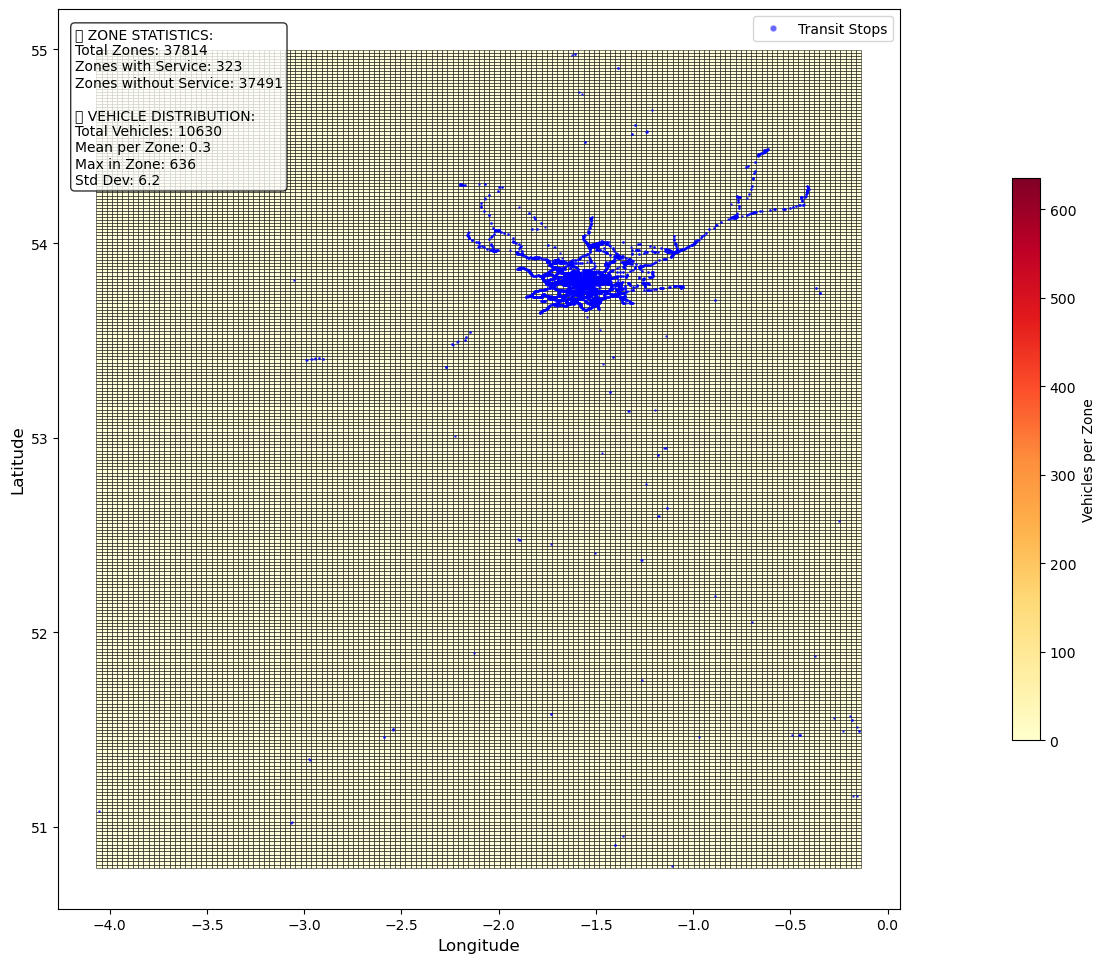

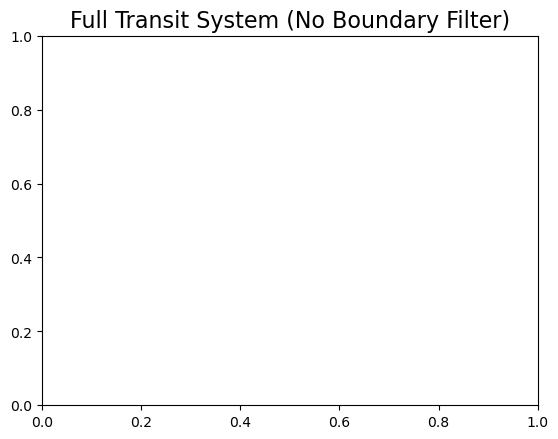

📊 Boundary-Filtered System (Standard Variance):


/home/hussein/Documents/GitHub/transit_opt/src/transit_opt/optimisation/spatial/zoning.py:729: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/hussein/Documents/GitHub/transit_opt/src/transit_opt/optimisation/spatial/zoning.py:729: UserWarning: Glyph 128652 (\N{BUS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128652 (\N{BUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


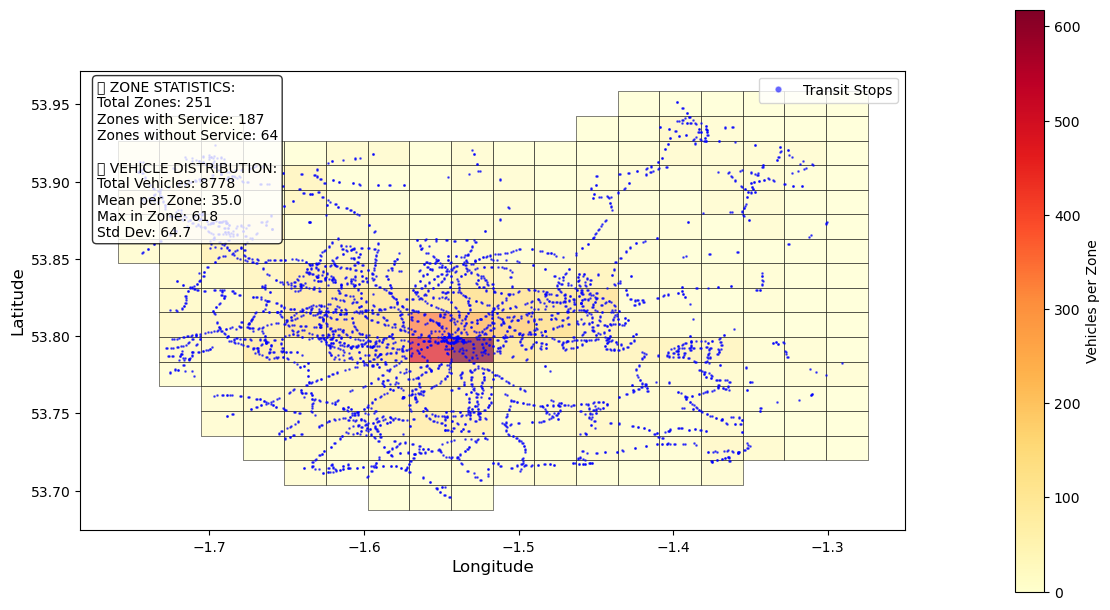

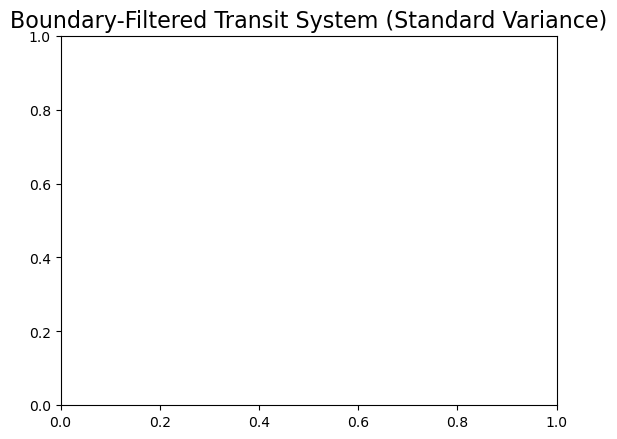

📊 Boundary-Filtered System with Spatial Lag Accessibility:
📊 Spatial lag calculated:
   Input mean: 34.97
   Spatial lag mean: 35.34
   Non-zero lags: 244
📊 Spatial lag calculated (α=0.15):
   Mean direct service: 34.97
   Mean neighbor service: 35.34
   Mean accessibility: 40.27
   Zones with improved access: 244
📊 Spatial lag calculated:
   Input mean: 50.00
   Spatial lag mean: 50.58
   Non-zero lags: 244
📊 Spatial lag calculated (α=0.15):
   Mean direct service: 50.00
   Mean neighbor service: 50.58
   Mean accessibility: 57.59
   Zones with improved access: 244


/tmp/ipykernel_702939/1587297944.py:102: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_702939/1587297944.py:102: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


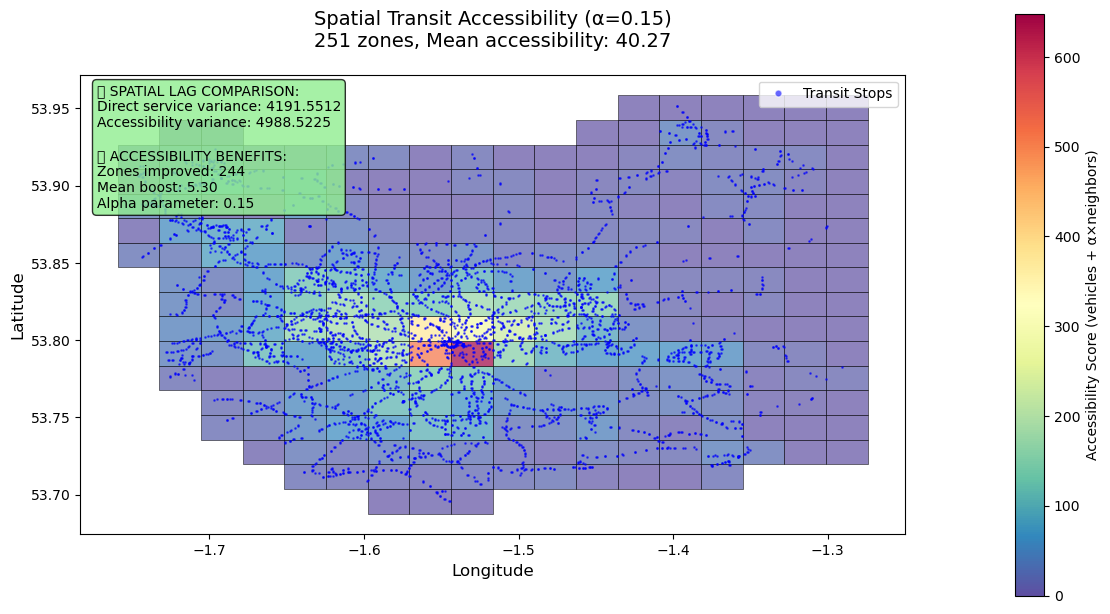

✅ All three visualization approaches created!

💡 Benefits comparison:
   • Boundary filtering: 99.3% fewer zones to process
   • Spatial lag: Accounts for neighbor accessibility effects
   • Accessibility scores: 40.27 vs 34.97 direct vehicles
   • Variance reduction: -19.0%


In [16]:
if study_boundary is not None:
    print("\n=== VISUALIZING BOUNDARY-FILTERED SYSTEM WITH SPATIAL LAG COMPARISON ===")

    # Create individual plots instead of subplots
    print("📊 Full System (No Boundary):")
    spatial_objective_full.spatial_system.visualize_spatial_coverage(
        solution_matrix=opt_data['initial_solution'],
        optimization_data=opt_data,
        figsize=(12, 10),
        show_stops=True
    )
    plt.title('Full Transit System (No Boundary Filter)', fontsize=16)
    plt.show()

    print("📊 Boundary-Filtered System (Standard Variance):")
    spatial_objective_bounded.spatial_system.visualize_spatial_coverage(
        solution_matrix=opt_data['initial_solution'],
        optimization_data=opt_data,
        figsize=(12, 10),
        show_stops=True
    )
    plt.title('Boundary-Filtered Transit System (Standard Variance)', fontsize=16)
    plt.show()

    # NEW: Create accessibility visualization for spatial lag approach
    print("📊 Boundary-Filtered System with Spatial Lag Accessibility:")

    # Get the spatial lag analysis data
    spatial_analysis = spatial_objective_spatial.get_detailed_analysis(opt_data['initial_solution'])

    # Create custom visualization showing accessibility scores
    zones_with_accessibility = spatial_objective_spatial.spatial_system.hex_grid.copy()
    zones_with_accessibility['accessibility'] = spatial_analysis['accessibility_scores_average']
    zones_with_accessibility['direct_vehicles'] = spatial_analysis['vehicles_per_zone_average']

    # Convert to geographic CRS for plotting
    zones_geo = zones_with_accessibility.to_crs("EPSG:4326")
    stops_geo = spatial_objective_spatial.spatial_system.stops_gdf.to_crs("EPSG:4326")

    # Create accessibility plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))

    # Plot zones with accessibility-based coloring
    if zones_with_accessibility['accessibility'].max() > 0:
        zones_geo.plot(
            ax=ax,
            column='accessibility',
            cmap='Spectral_r',  # Different colormap to distinguish from vehicle count
            alpha=0.7,
            edgecolor='black',
            linewidth=0.5,
            legend=True,
            legend_kwds={
                'label': 'Accessibility Score (vehicles + α×neighbors)',
                'orientation': 'vertical',
                'shrink': 0.6,
                'pad': 0.1
            }
        )
    else:
        zones_geo.plot(ax=ax, color='lightgray', alpha=0.5, edgecolor='black', linewidth=0.5)

    # Add transit stops
    stops_geo.plot(
        ax=ax,
        color='blue',
        markersize=0.8,
        alpha=0.6,
        label='Transit Stops'
    )

    # Customize the plot
    ax.set_title(f'Spatial Transit Accessibility (α=0.15)\n{len(zones_geo)} zones, Mean accessibility: {spatial_analysis["mean_accessibility_average"]:.2f}',
                fontsize=14, pad=20)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)

    # Add comparison statistics text box
    comparison_stats = [
        "🔄 SPATIAL LAG COMPARISON:",
        f"Direct service variance: {spatial_analysis['variance_average']:.4f}",
        f"Accessibility variance: {spatial_analysis['variance_accessibility_average']:.4f}",
        "",
        "📈 ACCESSIBILITY BENEFITS:",
        f"Zones improved: {np.sum(spatial_analysis['accessibility_scores_average'] > spatial_analysis['vehicles_per_zone_average'])}",
        f"Mean boost: {spatial_analysis['mean_accessibility_average'] - spatial_analysis['mean_vehicles_average']:.2f}",
        f"Alpha parameter: {spatial_analysis['spatial_lag_alpha']}"
    ]

    ax.text(0.02, 0.98, "\n".join(comparison_stats), transform=ax.transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

    # Add legend for stops
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue',
               markersize=5, label='Transit Stops', alpha=0.6)
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()

    print("✅ All three visualization approaches created!")
    print("\n💡 Benefits comparison:")
    print(f"   • Boundary filtering: {100*zone_reduction/len(spatial_objective_full.spatial_system.hex_grid):.1f}% fewer zones to process")
    print("   • Spatial lag: Accounts for neighbor accessibility effects")
    print(f"   • Accessibility scores: {spatial_analysis['mean_accessibility_average']:.2f} vs {spatial_analysis['mean_vehicles_average']:.2f} direct vehicles")
    print(f"   • Variance reduction: {((spatial_analysis['variance_average'] - spatial_analysis['variance_accessibility_average'])/spatial_analysis['variance_average']*100):+.1f}%")

📊 Spatial lag calculated:
   Input mean: 34.97
   Spatial lag mean: 35.34
   Non-zero lags: 244
📊 Spatial lag calculated (α=0.15):
   Mean direct service: 34.97
   Mean neighbor service: 35.34
   Mean accessibility: 40.27
   Zones with improved access: 244
📊 Spatial lag calculated:
   Input mean: 50.00
   Spatial lag mean: 50.58
   Non-zero lags: 244
📊 Spatial lag calculated (α=0.15):
   Mean direct service: 50.00
   Mean neighbor service: 50.58
   Mean accessibility: 57.59
   Zones with improved access: 244


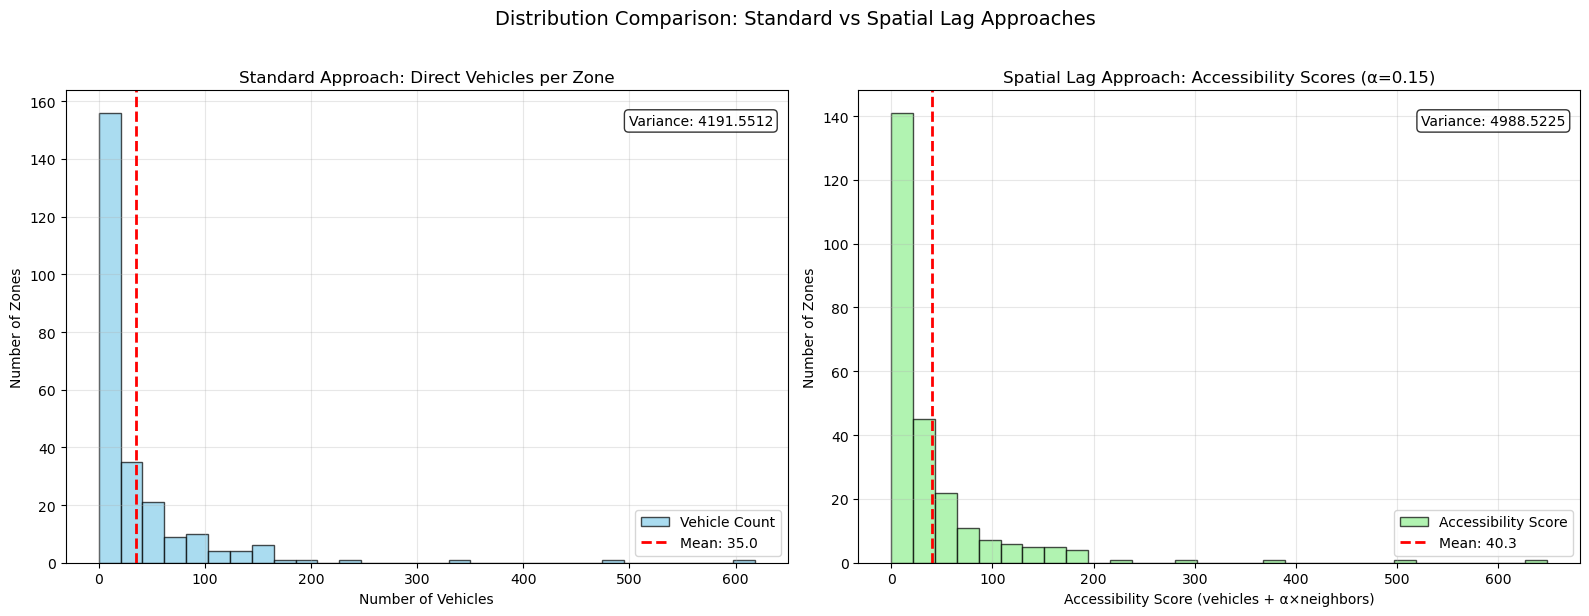

📊 DISTRIBUTION COMPARISON:
Standard approach:
   Mean: 34.97, Std: 64.74, Variance: 4191.5512
   Range: 0.0 to 618.0
Spatial lag approach (α=0.15):
   Mean: 40.27, Std: 70.63, Variance: 4988.5225
   Range: 0.0 to 648.3
Variance change: +19.0%


In [17]:
# Enhanced histogram showing standard vs spatial lag approaches
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Get data from both approaches
standard_analysis = spatial_objective_bounded.get_detailed_analysis(opt_data['initial_solution'])
spatial_analysis = spatial_objective_spatial.get_detailed_analysis(opt_data['initial_solution'])

vehicles_per_zone = standard_analysis['vehicles_per_zone_average']
accessibility_scores = spatial_analysis['accessibility_scores_average']

n_bins = 30  # Good balance for visualization

# Plot 1: Standard vehicle distribution
axes[0].hist(vehicles_per_zone, bins=n_bins, color='skyblue', edgecolor='black', alpha=0.7, label='Vehicle Count')
axes[0].axvline(np.mean(vehicles_per_zone), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(vehicles_per_zone):.1f}')
axes[0].set_title('Standard Approach: Direct Vehicles per Zone')
axes[0].set_xlabel('Number of Vehicles')
axes[0].set_ylabel('Number of Zones')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Add variance text
axes[0].text(0.98, 0.95, f'Variance: {np.var(vehicles_per_zone):.4f}',
             transform=axes[0].transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 2: Spatial lag accessibility distribution
axes[1].hist(accessibility_scores, bins=n_bins, color='lightgreen', edgecolor='black', alpha=0.7, label='Accessibility Score')
axes[1].axvline(np.mean(accessibility_scores), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(accessibility_scores):.1f}')
axes[1].set_title('Spatial Lag Approach: Accessibility Scores (α=0.15)')
axes[1].set_xlabel('Accessibility Score (vehicles + α×neighbors)')
axes[1].set_ylabel('Number of Zones')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# Add variance text
axes[1].text(0.98, 0.95, f'Variance: {np.var(accessibility_scores):.4f}',
             transform=axes[1].transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('Distribution Comparison: Standard vs Spatial Lag Approaches', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Print comparison statistics
print("📊 DISTRIBUTION COMPARISON:")
print("Standard approach:")
print(f"   Mean: {np.mean(vehicles_per_zone):.2f}, Std: {np.std(vehicles_per_zone):.2f}, Variance: {np.var(vehicles_per_zone):.4f}")
print(f"   Range: {np.min(vehicles_per_zone):.1f} to {np.max(vehicles_per_zone):.1f}")

print("Spatial lag approach (α=0.15):")
print(f"   Mean: {np.mean(accessibility_scores):.2f}, Std: {np.std(accessibility_scores):.2f}, Variance: {np.var(accessibility_scores):.4f}")
print(f"   Range: {np.min(accessibility_scores):.1f} to {np.max(accessibility_scores):.1f}")

variance_change = ((np.var(accessibility_scores) - np.var(vehicles_per_zone)) / np.var(vehicles_per_zone)) * 100
print(f"Variance change: {variance_change:+.1f}%")

📊 Spatial lag calculated:
   Input mean: 0.42
   Spatial lag mean: 0.42
   Non-zero lags: 46
📊 Spatial lag calculated (α=0.15):
   Mean direct service: 0.42
   Mean neighbor service: 0.42
   Mean accessibility: 0.49
   Zones with improved access: 46
📊 Spatial lag calculated:
   Input mean: 23.94
   Spatial lag mean: 24.10
   Non-zero lags: 213
📊 Spatial lag calculated (α=0.15):
   Mean direct service: 23.94
   Mean neighbor service: 24.10
   Mean accessibility: 27.56
   Zones with improved access: 213
📊 Spatial lag calculated:
   Input mean: 46.57
   Spatial lag mean: 47.07
   Non-zero lags: 244
📊 Spatial lag calculated (α=0.15):
   Mean direct service: 46.57
   Mean neighbor service: 47.07
   Mean accessibility: 53.63
   Zones with improved access: 244
📊 Spatial lag calculated:
   Input mean: 46.98
   Spatial lag mean: 47.55
   Non-zero lags: 244
📊 Spatial lag calculated (α=0.15):
   Mean direct service: 46.98
   Mean neighbor service: 47.55
   Mean accessibility: 54.11
   Zones with 

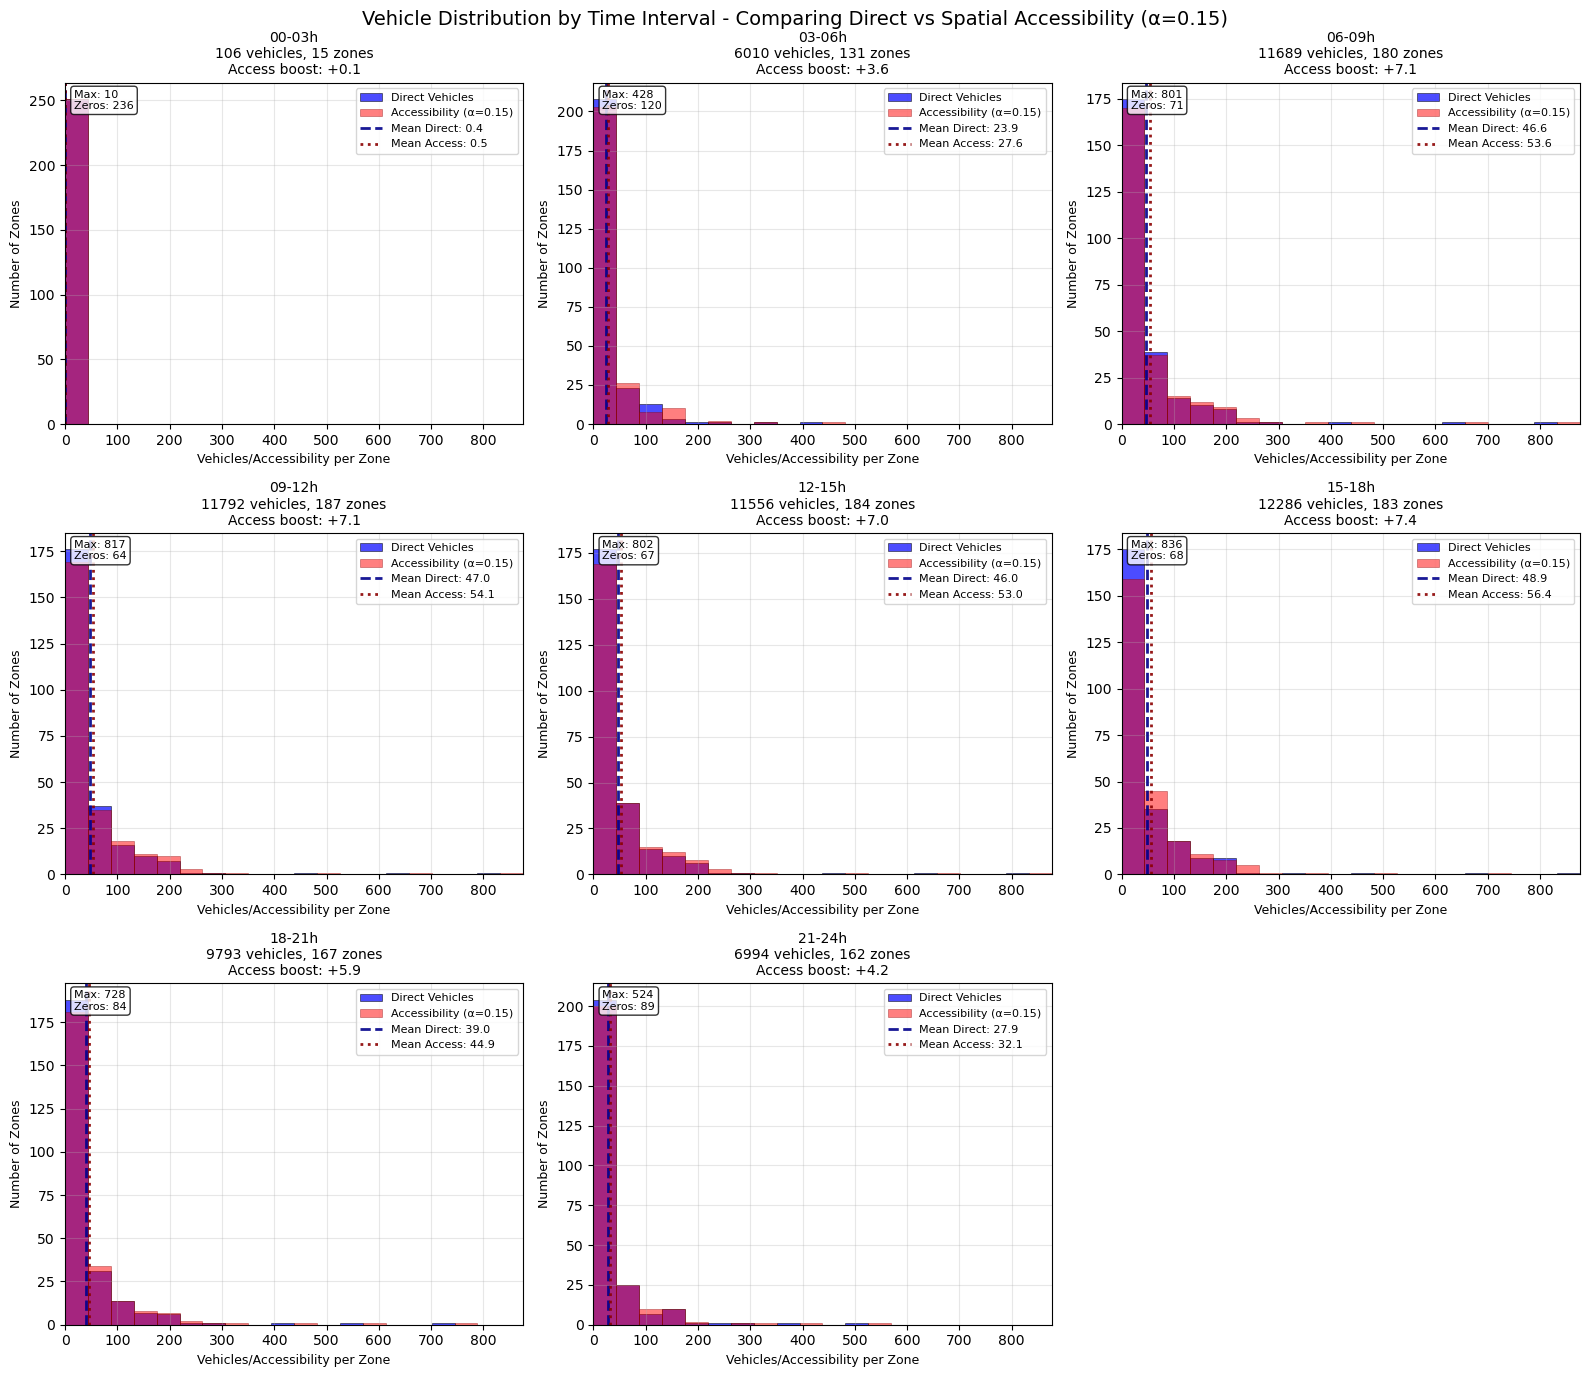

📊 SUMMARY STATISTICS:
      00-03h:  106 vehicles,  15 zones, mean  0.4
      03-06h: 6010 vehicles, 131 zones, mean 23.9
      06-09h: 11689 vehicles, 180 zones, mean 46.6
      09-12h: 11792 vehicles, 187 zones, mean 47.0
      12-15h: 11556 vehicles, 184 zones, mean 46.0
      15-18h: 12286 vehicles, 183 zones, mean 48.9
      18-21h: 9793 vehicles, 167 zones, mean 39.0
      21-24h: 6994 vehicles, 162 zones, mean 27.9


In [18]:
def create_enhanced_faceted_histogram(spatial_objective, opt_data, figsize=(16, 14)):
    """Create faceted histograms showing both direct vehicles and accessibility by time interval."""

    vehicles_data = spatial_objective.spatial_system._vehicles_per_zone(opt_data['initial_solution'], opt_data)
    intervals_data = vehicles_data['intervals']  # Shape: (n_zones, n_intervals)
    interval_labels = vehicles_data['interval_labels']
    n_intervals = len(interval_labels)

    # Get accessibility data if spatial lag is enabled
    has_spatial_lag = hasattr(spatial_objective, 'spatial_lag') and spatial_objective.spatial_lag
    if has_spatial_lag:
        accessibility_data = np.zeros_like(intervals_data)
        for i in range(n_intervals):
            accessibility_data[:, i] = spatial_objective.spatial_system._calculate_accessibility_scores(
                intervals_data[:, i], spatial_objective.alpha
            )

    # Calculate subplot layout
    n_cols = int(np.ceil(np.sqrt(n_intervals)))
    n_rows = int(np.ceil(n_intervals / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if n_intervals > 1 else [axes]

    # IMPROVED: Better binning strategy
    all_values = intervals_data.flatten()
    if has_spatial_lag:
        all_values = np.concatenate([all_values, accessibility_data.flatten()])

    # Use fewer, wider bins for better readability
    max_vehicles = int(np.max(all_values))
    if max_vehicles <= 10:
        # For small ranges, use integer bins
        bins = np.arange(0, max_vehicles + 2) - 0.5
    else:
        # For larger ranges, use ~15-20 bins for better visualization
        n_bins = min(20, max_vehicles // 2 + 1)
        bins = np.linspace(-0.5, max_vehicles + 0.5, n_bins + 1)

    for i in range(n_intervals):
        ax = axes[i]
        interval_vehicles = intervals_data[:, i]

        # Plot direct vehicles with better styling
        ax.hist(interval_vehicles, bins=bins, alpha=0.7, edgecolor='black',
                color='blue', label='Direct Vehicles', linewidth=0.5)

        # Plot accessibility if available
        if has_spatial_lag:
            interval_accessibility = accessibility_data[:, i]
            ax.hist(interval_accessibility, bins=bins, alpha=0.5, edgecolor='darkred',
                    color='red', label=f'Accessibility (α={spatial_objective.alpha})', linewidth=0.5)

        # Add statistics with CLEARER LABELS
        mean_vehicles = np.mean(interval_vehicles)
        total_vehicles = np.sum(interval_vehicles)
        zones_with_service = np.sum(interval_vehicles > 0)

        # IMPROVED: More visible vertical lines with labels
        line1 = ax.axvline(mean_vehicles, color='darkblue', linestyle='--', linewidth=2, alpha=0.9,
                          label=f'Mean Direct: {mean_vehicles:.1f}')

        if has_spatial_lag:
            mean_accessibility = np.mean(interval_accessibility)
            line2 = ax.axvline(mean_accessibility, color='darkred', linestyle=':', linewidth=2, alpha=0.9,
                              label=f'Mean Access: {mean_accessibility:.1f}')

        # IMPROVED: Cleaner subplot titles
        title = f'{interval_labels[i]}'
        subtitle = f'{total_vehicles:.0f} vehicles, {zones_with_service} zones'
        if has_spatial_lag:
            subtitle += f'\nAccess boost: +{mean_accessibility - mean_vehicles:.1f}'

        ax.set_title(f'{title}\n{subtitle}', fontsize=10)
        ax.set_xlabel('Vehicles/Accessibility per Zone', fontsize=9)
        ax.set_ylabel('Number of Zones', fontsize=9)
        ax.grid(True, alpha=0.3)

        # IMPROVED: Show legend on each subplot for clarity
        ax.legend(fontsize=8, loc='upper right')

        # Better x-axis limits
        ax.set_xlim(-0.5, max_vehicles + 0.5)

        # Add text box with key stats
        stats_text = f'Max: {np.max(interval_vehicles):.0f}\nZeros: {np.sum(interval_vehicles == 0)}'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
                verticalalignment='top', fontsize=8,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

    # Hide empty subplots
    for i in range(n_intervals, len(axes)):
        axes[i].set_visible(False)

    # IMPROVED: Better main title
    main_title = 'Vehicle Distribution by Time Interval'
    if has_spatial_lag:
        main_title += f' - Comparing Direct vs Spatial Accessibility (α={spatial_objective.alpha})'
    plt.suptitle(main_title, fontsize=14, y=0.98)

    plt.tight_layout()
    plt.show()

    # ADDED: Print summary statistics
    print("📊 SUMMARY STATISTICS:")
    for i, label in enumerate(interval_labels):
        vehicles = intervals_data[:, i]
        print(f"{label:>12}: {np.sum(vehicles):>4.0f} vehicles, {np.sum(vehicles > 0):>3} zones, mean {np.mean(vehicles):>4.1f}")

    return fig

# Use it with spatial lag objective
if study_boundary is not None:
    create_enhanced_faceted_histogram(spatial_objective_spatial, opt_data)

In [19]:
# Get all vehicle data for zones
vehicles_data = spatial_objective_bounded.spatial_system._vehicles_per_zone(
    opt_data['initial_solution'],
    opt_data
)

print("Available data:")
print(f"- Average vehicles per zone: {vehicles_data['average'].shape}")
print(f"- Peak vehicles per zone: {vehicles_data['peak'].shape}")
print(f"- Vehicles by interval: {vehicles_data['intervals'].shape}")
print(f"- Interval labels: {vehicles_data['interval_labels']}")

# Access specific data
average_per_zone = vehicles_data['average']  # Shape: (n_zones,)
peak_per_zone = vehicles_data['peak']        # Shape: (n_zones,)
intervals_data = vehicles_data['intervals']   # Shape: (n_zones, n_intervals)

print("\nExample zone data:")
print(f"Zone 0: average={average_per_zone[0]:.1f}, peak={peak_per_zone[0]:.1f}")
print(f"Zone 0 by interval: {intervals_data[0, :]}")

Available data:
- Average vehicles per zone: (251,)
- Peak vehicles per zone: (251,)
- Vehicles by interval: (251, 8)
- Interval labels: ['00-03h', '03-06h', '06-09h', '09-12h', '12-15h', '15-18h', '18-21h', '21-24h']

Example zone data:
Zone 0: average=17.2, peak=28.0
Zone 0 by interval: [ 0.  0. 24. 25. 25. 28. 24. 12.]


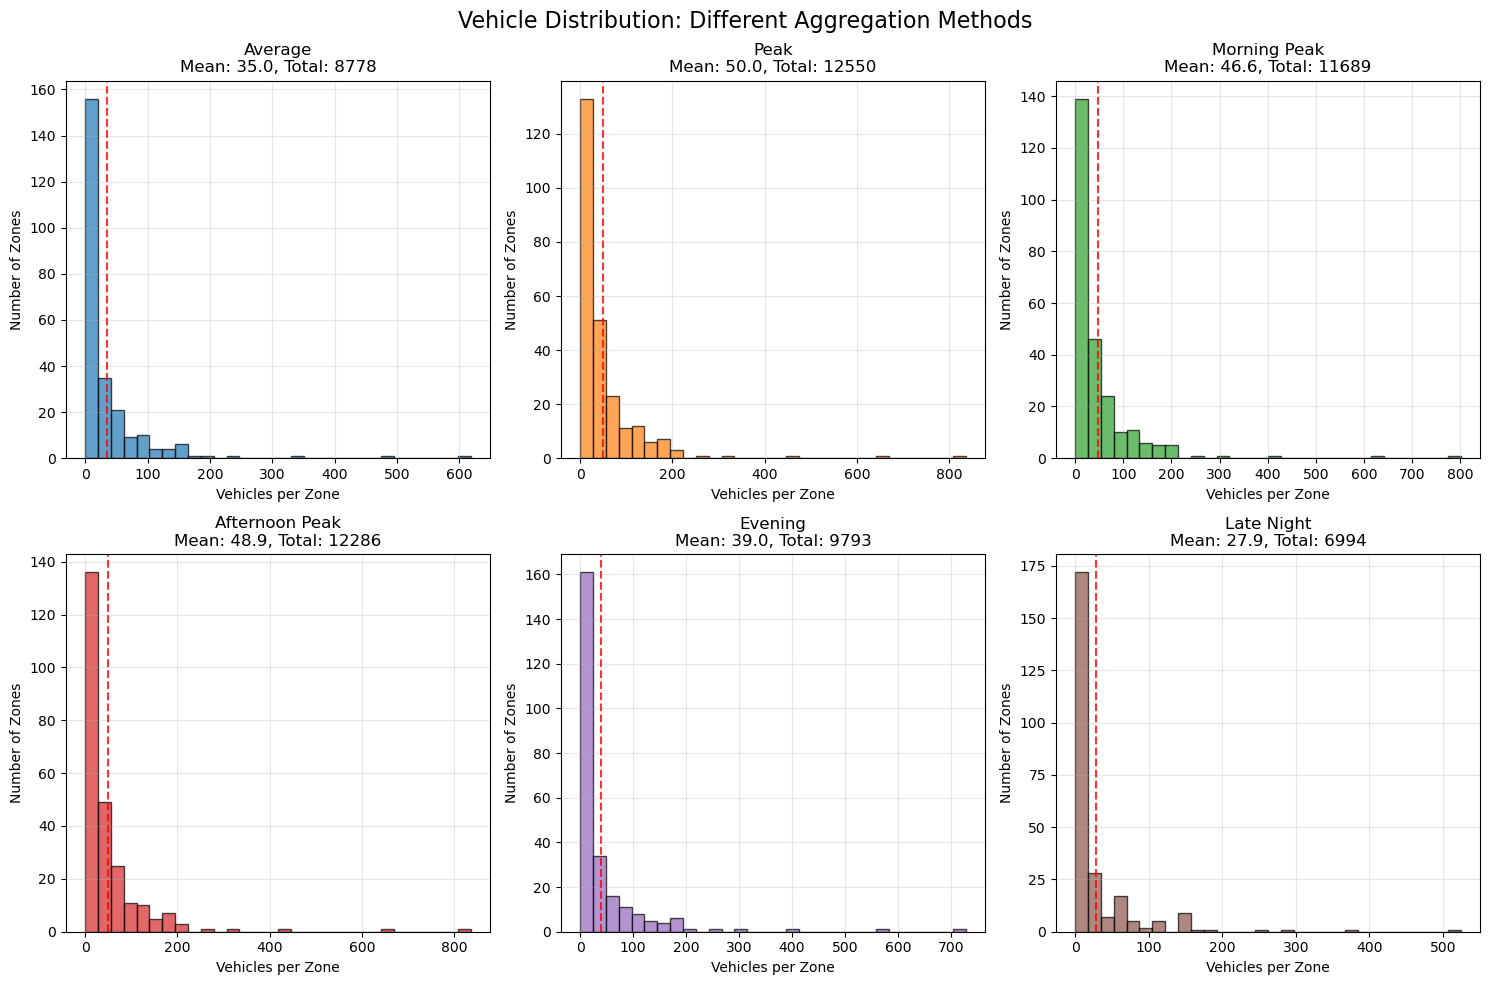

In [20]:
def create_aggregation_comparison(vehicles_data, figsize=(15, 10)):
    """Compare different aggregation methods."""

    fig, axes = plt.subplots(2, 3, figsize=figsize)

    # Data to plot
    plot_data = [
        ('Average', vehicles_data['average']),
        ('Peak', vehicles_data['peak']),
        ('Morning Peak', vehicles_data['intervals'][:, 2]),  # Assuming interval 2 is morning
        ('Afternoon Peak', vehicles_data['intervals'][:, 5]),  # Assuming interval 5 is afternoon
        ('Evening', vehicles_data['intervals'][:, 6]),  # Assuming interval 6 is evening
        ('Late Night', vehicles_data['intervals'][:, 7])   # Assuming interval 7 is late night
    ]

    axes = axes.flatten()

    for i, (title, data) in enumerate(plot_data):
        ax = axes[i]

        # Create histogram
        ax.hist(data, bins=30, alpha=0.7, edgecolor='black', color=f'C{i}')

        # Add statistics
        mean_val = np.mean(data)
        total_vehicles = np.sum(data)
        zones_with_service = np.sum(data > 0)

        ax.axvline(mean_val, color='red', linestyle='--', alpha=0.8)

        # Customize
        ax.set_title(f'{title}\nMean: {mean_val:.1f}, Total: {total_vehicles:.0f}')
        ax.set_xlabel('Vehicles per Zone')
        ax.set_ylabel('Number of Zones')
        ax.grid(True, alpha=0.3)

    plt.suptitle('Vehicle Distribution: Different Aggregation Methods', fontsize=16)
    plt.tight_layout()
    plt.show()

create_aggregation_comparison(vehicles_data)